In [6]:
# My little random quote bot

In [15]:
import requests
import json
import numpy as np
import pandas as pd
import time

%matplotlib inline
import matplotlib.pyplot as plt



In [16]:
#baseurl = 'https://blocmarket.herokuapp.com/'
# baseurl = 'http://127.0.0.1:5000/'
baseurl = 'http://127.0.0.1:7000/'

In [17]:
# Create a new user
url = baseurl +'createUser'
headers = {'content-type': 'application/json'}
content = {}
response = requests.post(url, data=json.dumps(content), headers=headers)

In [18]:
# View response as json
response.json()

{'signingKey': '2bdc0a7efa8b99ceed3f2c89067bc97fd473d2fdb4644fbb81ac7f5d31c15be4',
 'traderId': '6',
 'verifyKey': 'baab44f23fb2d35dd8b6366fd5dad07fefce87aa067e4dfe3d81ac481473cfd5'}

In [19]:
# Copy keys and traderid from response
sk = response.json()['signingKey']
vk = response.json()['verifyKey']
tId = int(response.json()['traderId'])


In [20]:
# Create a new market
mkRtId = tId
mkBrId = 1


url = baseurl + 'createMarket'
content_makemarket = {"signingKey": sk,
                        "traderId": tId, 
                        "verifyKey": vk,
                        "marketRootId": mkRtId, 
                        "marketBranchId": mkBrId, 
                        "marketMin": 0,
                        "marketMax":1}
# Post market
response = requests.post(url, data=json.dumps(content_makemarket), headers=headers)


In [21]:
# response = requests.post(url, data=json.dumps(content_makemarket), headers=headers)
# View response as json
response.json()

{'allChecks': "{'inputChk': True, 'marketLimitChk': True, 'traderIdChk': True, 'marketId': '6', 'marketRangeChk': True, 'marketIndChk': True, 'sigChk': True, 'chainChk': True, 'ownerChk': True, 'timeChk': True}",
 'checks': 'True',
 'marketBranchId': 1,
 'marketId': 6,
 'marketMax': 1,
 'marketMin': 0,
 'marketRootId': 6,
 'traderId': 6}

In [22]:
# Save market id from response
mkId = response.json()['marketId']
mkId

6

In [23]:
# Create a trade
tradeurl = baseurl+'createTrade'

content_maketrade = {"signingKey": sk,
                     "traderId": tId,
                     "verifyKey": vk,
                     "marketId": int(mkId),
                     "price":0.5,
                     "quantity": 1}
response = requests.post(tradeurl, data=json.dumps(content_maketrade), headers=headers)

In [24]:
# View response as json
response.json()

{'allChecks': "{'inputChk': True, 'traderIdChk': True, 'marketChk': True, 'sigChk': True, 'chainChk': True, 'timeChk': True, 'colChk': True}",
 'checks': 'True',
 'marketId': 6,
 'price': 0.5,
 'quantity': 1,
 'traderId': 6}

In [27]:
# A simple robot making a bid/offer with an OU process

url = baseurl+'createTrade'

m = 0.5
k = -0.001
v = 0.01
B = m
i=0
stillQuoting=True
while stillQuoting:
    i+=1
    # Create bounded [0,1] random reverting to m
    dW = np.random.normal()
    if i==0:
        dLnB = v*dW
    else:
        dLnB = -k*(np.log(B)-m) + v*dW
    
    # Bound between zero and one
    B *= np.exp(dLnB)
    B = min(max(B, 0.01),0.99)
    
    # Make a bid
    content_maketrade['price'] = B-0.01
    content_maketrade['quantity'] =1
    response = requests.post(url, data=json.dumps(content_maketrade), headers=headers)
    # Make an offer
    content_maketrade['price'] = B+0.01
    content_maketrade['quantity'] = -1
    response = requests.post(url, data=json.dumps(content_maketrade), headers=headers)
    time.sleep(5)
    
    # Remove bid
    content_maketrade['price'] = B-0.01
    content_maketrade['quantity'] =-1
    response = requests.post(url, data=json.dumps(content_maketrade), headers=headers)
    # Remove offer
    content_maketrade['price'] = B+0.01
    content_maketrade['quantity'] = 1
    response = requests.post(url, data=json.dumps(content_maketrade), headers=headers)
    print('Price for iteration ' + str(i) + ' : ' + str(content_maketrade['price']))

Price for iteration 1 : 0.5068583857278959
Price for iteration 2 : 0.4958325218062393
Price for iteration 3 : 0.4981668391192661
Price for iteration 4 : 0.49782561302520545
Price for iteration 5 : 0.49742474423462124
Price for iteration 6 : 0.4886982543832016
Price for iteration 7 : 0.49562149092157853
Price for iteration 8 : 0.4924561181688881
Price for iteration 9 : 0.4990589781140533
Price for iteration 10 : 0.5015868104121523
Price for iteration 11 : 0.5062852307785599
Price for iteration 12 : 0.5039659701165449
Price for iteration 13 : 0.5016866885886391
Price for iteration 14 : 0.5104154784206181
Price for iteration 15 : 0.5075765675192884
Price for iteration 16 : 0.4978123679973149
Price for iteration 17 : 0.500283930130334
Price for iteration 18 : 0.4994117264674303
Price for iteration 19 : 0.49932916757230567
Price for iteration 20 : 0.5007167632099779
Price for iteration 21 : 0.5066095063414555
Price for iteration 22 : 0.5045618125478333
Price for iteration 23 : 0.50895820883

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [13]:
# Get summary for this market and plot

url = baseurl+'viewTradeSummary'
content = {'traderId': int(tId)}
response = requests.post(url, data=json.dumps(content), headers=headers, stream=True)
a = pd.read_json(response.json())
a = a[a['marketId'] == mkId]
a = a.set_index(a['timeStampUTC'])


Text(0.5, 1.0, 'Time series for market 3 / trader 3')

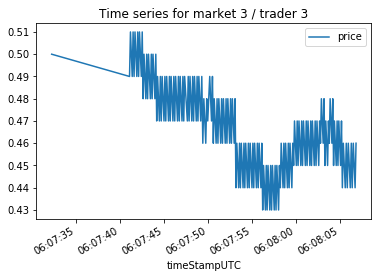

In [14]:
plt.figure(); a['price'].plot(); plt.legend(loc='best'); plt.title('Time series for market ' + str(mkId) + ' / trader ' +str(tId))

Text(0.5, 1.0, 'Time series for market 6 / trader 6')

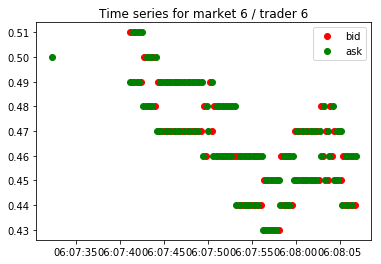

In [28]:
bids = a[a['quantity']<0]
asks = a[a['quantity']>0]

plt.figure(); 
plt.plot(bids['timeStampUTC'],bids['price'], 'ro');
plt.plot(asks['timeStampUTC'],asks['price'], 'go');
plt.legend(('bid', 'ask')); plt.title('Time series for market ' + str(mkId) + ' / trader ' +str(tId))
